In [2]:
#-*- coding : utf-8-*-
#coding:unicode_escape
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer,cosine_distance,euclidean_distance
from sklearn import metrics
from sklearn import mixture
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
import nltk
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans, MiniBatchKMeans
# from yellowbrick.cluster.elbow import kelbow_visualize
import re
import random
import emoji
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV
import chardet
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize, sent_tokenize, pos_tag
nltk.download ('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Kelvin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kelvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Kelvin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Kelvin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kelvin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Data Preprocessing

In [5]:
data = pd.read_csv("C:/Users/Kelvin/Desktop/Assignment/2022Spring/BIA686/wine_train.csv")
data2 = pd.read_csv("C:/Users/Kelvin/Desktop/Assignment/2022Spring/BIA686/wine_test.csv")
data.reset_index(drop = True, inplace = True)
data2.reset_index(drop = True, inplace = True)
data = pd.concat([data, data2], ignore_index = True)
data.to_csv("C:/Users/Kelvin/Desktop/Assignment/2022Spring/BIA686/Wine.csv",index = False)
dataset = data.replace('null',np.NaN)
dataset = dataset.drop(labels = [ 'region_2','taster_twitter_handle','taster_name','winery' ] , axis = 1)
dataset.isnull().sum()
df = dataset.loc[:,['country', 'province','region_1', 'variety',  'points', 'price' ,'description','designation'] ]
data1 = df.dropna()
data1 = data1.drop_duplicates()
def preprocess_text(text):
    text = remove_numbers(text)
#     text = remove_http(text)
    text = remove_punctuation(text)
    text = convert_to_lower(text)
    text = remove_white_space(text)
    text = remove_short_words(text)
    tokens = toknizing(text)
    # 2. POS tagging
    pos_map = {'J': 'a', 'N': 'n', 'R': 'r', 'V': 'v'}
    pos_tags_list = pos_tag(tokens)
    # print(pos_tags)
    lemmatiser = WordNetLemmatizer()
    tokens = [lemmatiser.lemmatize(w.lower(), 
                                   pos=pos_map.get(p[0], 'v')) 
              for w, p in pos_tags_list]
    return tokens
def convert_to_lower(text):
    return text.lower()
def remove_numbers(text):
    text = re.sub(r'\d+' , '', text)
    return text
# def remove_http(text):
#     text = re.sub("https?:\/\/t.co\/[A-Za-z0-9]*", ' ', text)
#     return text
def remove_short_words(text):
    text = re.sub(r'\b\w{1,2}\b', '', text)
    return text
def remove_punctuation(text):
    punctuations = '''!()[]{};«№»:'"\,`<>./?@=#$-(%^)+&[*_]~'''
    no_punct = ""
    for char in text:
        if char not in punctuations:
            no_punct = no_punct + char
    return no_punct
def remove_white_space(text):
    text = text.strip()
    return text
def toknizing(text):
#     stp = my_stopwords
#     stops = set(stopwords.words('english'))
    stop_words = set('english')
    tokens = word_tokenize(text)
    result = [i for i in tokens if not i in stop_words]
    return result
data1['description'] = data1['description'].apply(preprocess_text)
data_pre = data1
for i in range(len(data_pre)):
    data_pre.iloc[i,6] = ','.join(str(i) for i in data_pre.iloc[i,6])
data_pre1 = data_pre.replace("\,",' ',regex=True)

Unnamed: 0         0
country           50
description        0
designation    30039
points             0
price           7208
province          50
region_1       16973
title              0
variety            1
dtype: int64

# Word Cloud

(-0.5, 2999.5, 1999.5, -0.5)

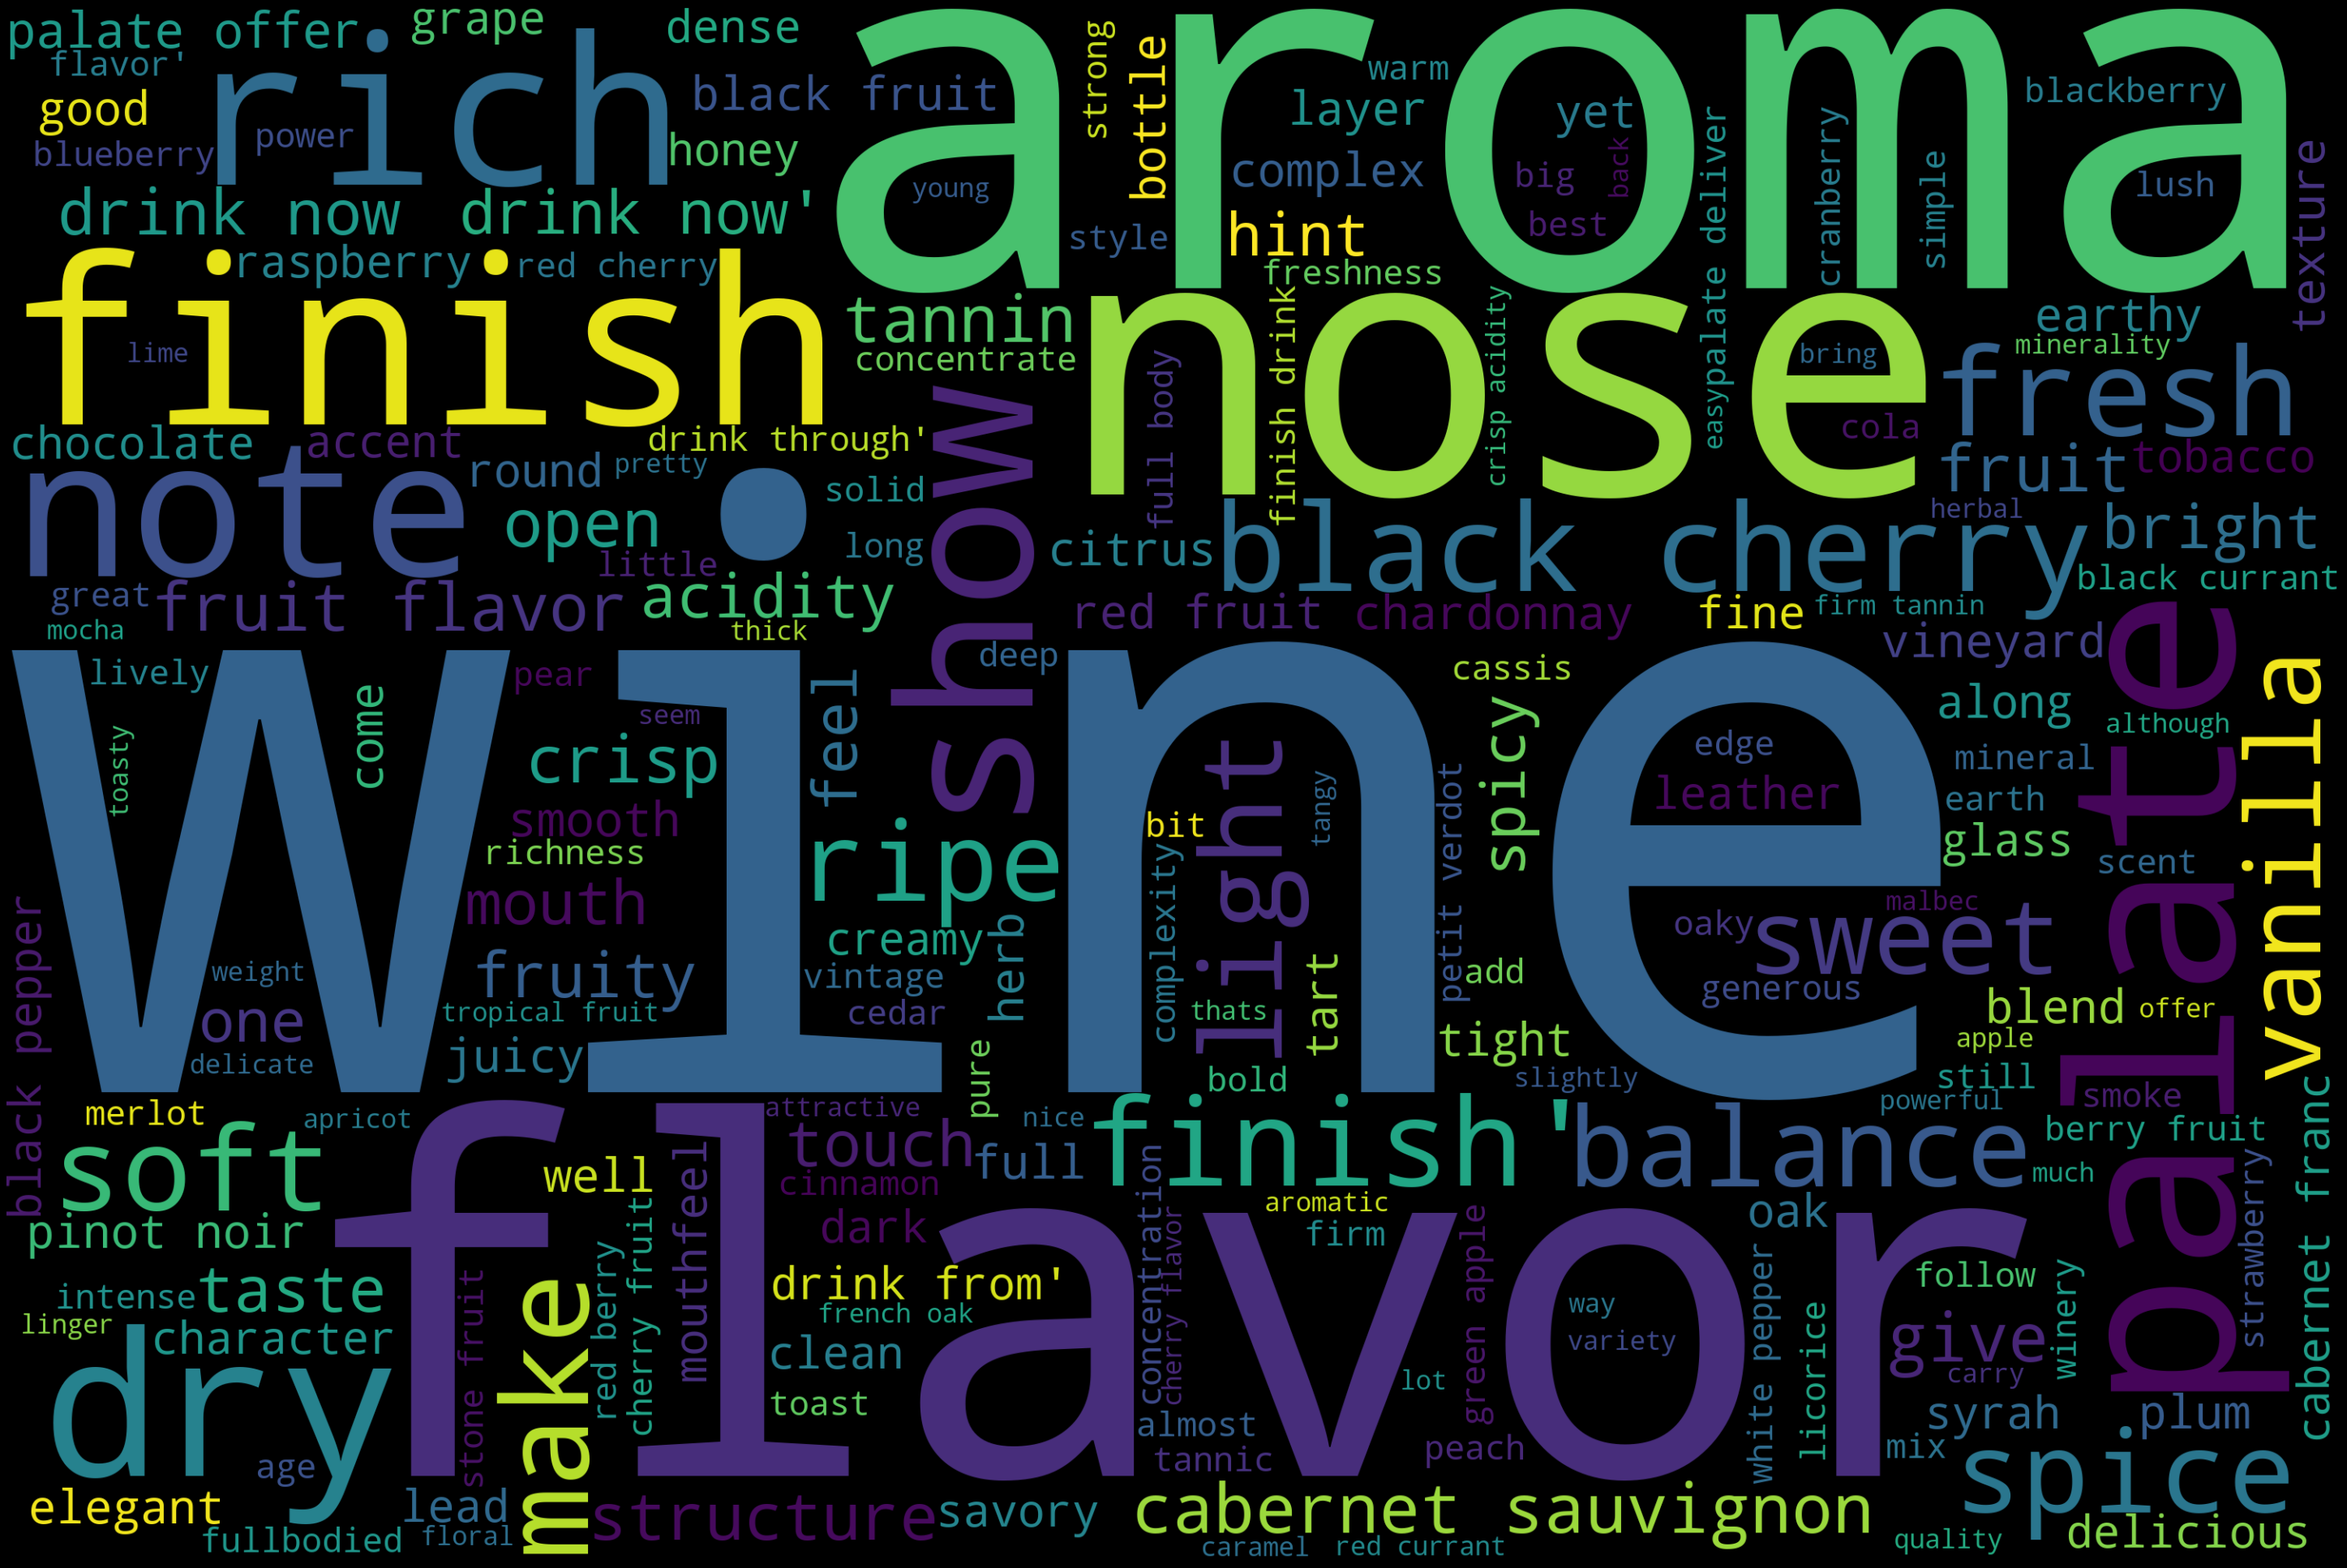

In [6]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
word = []
for i in range(len(data_pre1)):
    word.append(data_pre1.iloc[i,6])
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(word))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# TF-IDF & kNN Model

In [15]:
def Recommendation(newData):
    newData = [newData]
    newData_tfidfVect = TfidfVectorizer()
    newData_tfidfVect = newData_tfidfVect.fit(data_pre1['description'])
    newData_tfidf = newData_tfidfVect.transform(newData)
    tfidfVect = TfidfVectorizer()
    tfidf = tfidfVect.fit_transform(data_pre1['description'])
    nbrs = NearestNeighbors(n_neighbors=10).fit(tfidf)
    distances, indices = nbrs.kneighbors(newData_tfidf)
    index = pd.DataFrame(data = indices[0:,0:])
    data_pre1['number'] = 0
    for i in range(len(data_pre1)):
        data_pre1.iloc[i,8] = i
    result = pd.DataFrame()
    b = pd.DataFrame()
    for i in range(10):
      if i == 0:
         a = index.iloc[0,0]
         result = data_pre1[data_pre1['number'] == a]
         b = result
      else:
#         for j in range(df.shape[1]):
         a = index.iloc[0,i]
         result = data_pre1[data_pre1['number'] == a]
         b = pd.concat([b, result])
    recommendation = b.drop([ 'description', 'number'], axis = 1)

    return recommendation

# Result

In [22]:
recommendation = Recommendation(newData = 'they burst with mineral and fruit notes that lead into prickly, savory, mouth-drying tannins')
recommendation
print ('Average points: \n',recommendation1['points'].mean())
print ('Average price: \n', recommendation1['price'].mean())

,country,province,region_1,variety,points,price,designation
45933,US,New York,Finger Lakes,Merlot,84,24.0,Barrel Reserve
15241,Italy,Southern Italy,Puglia,Nero di Troia,86,14.0,Alta
51900,US,California,Paso Robles,Red Blend,82,30.0,Ruby
60683,Italy,Piedmont,Barolo,Nebbiolo,93,104.0,Cannubi
23254,Argentina,Other,San Juan,Malbec,88,20.0,Paz
30750,US,California,Napa Valley,Cabernet Sauvignon,85,65.0,Estate
59669,Italy,Southern Italy,Campi Flegrei,Piedirosso,87,18.0,Colle Rotondella
54205,US,New York,Finger Lakes,Barbera,85,15.0,Estate Reserve
51935,US,Idaho,Idaho,G-S-M,89,30.0,Arrow Rim
79966,US,Oregon,Rogue Valley,Tempranillo,86,32.0,Estate


Average points: 
 86.5
Average price: 
 35.2
